На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
 
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Описание данных
5_task_1:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

5_task_2:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

1. Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:


- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

In [119]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


sns.set(rc = {'figure.figsize':(16,6)}, style = 'whitegrid')

In [3]:
exp1 = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_1.csv')
exp1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [6]:
exp1.shape

(30000, 3)

In [8]:
exp1.group.value_counts()

C    10000
A    10000
B    10000
Name: group, dtype: int64

In [40]:
groupA_mean = exp1[exp1.group == 'A'].events.mean()
groupB_mean = exp1[exp1.group == 'B'].events.mean()
groupC_mean = exp1[exp1.group == 'C'].events.mean()
print(groupA_mean, groupB_mean, groupC_mean)

29.5796 37.6136 27.4703


In [13]:
groupA = exp1[exp1.group == 'A'].events
groupB = exp1[exp1.group == 'B'].events
groupC = exp1[exp1.group == 'C'].events

In [15]:
# Проверка на гомогенность дисперсий групп с помощью теста Левена
stats.levene(groupA, groupB, groupC)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05, не отклоняем нулевую гипотезу о гомогенности дисперсий

In [39]:
# Проверка на нормальность распределения данных с помощью теста Шапиро-Уилка
test1 = stats.shapiro(groupA.sample(n = 1000, random_state = 17))
test2 = stats.shapiro(groupB.sample(n = 1000, random_state = 17))
test3 = stats.shapiro(groupC.sample(n = 1000, random_state = 17))
print(test1, test2, test3, sep = '\n')

(0.9973153471946716, 0.09609563648700714)
(0.9980798363685608, 0.31768906116485596)
(0.9981185793876648, 0.3359004259109497)


p-value > 0.05 во всех трех случаях, не отклоняем нулевую гипотезу о нормальности распределения

In [42]:
# воспользуемся однофакторным дисперсионным анализом для сравнения средних в группах
stats.f_oneway(groupA, groupB, groupC)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

pvalue близок к 0, следовательно, статистические значимые различия между средними групп есть

In [48]:
# Проверка, между какими группами есть различия с помощью критерия Тьюки
pairwise_tukeyhsd(exp1.events, groups = exp1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


Между всеми группами есть значимые различия

Text(0, 0.5, 'Число покупок')

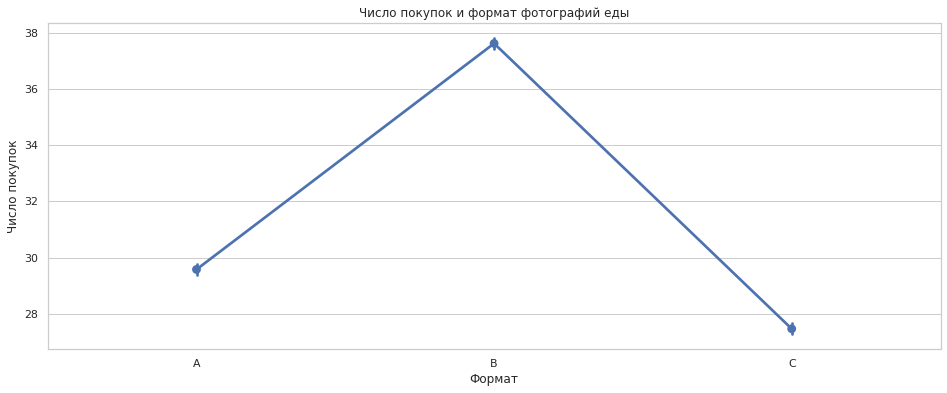

In [52]:
sns.pointplot(x = 'group', y = 'events', data = exp1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

Итог: так как между всеми группами есть статистически значимые различия, то рационально использовать квадратные картинки. Данный формат показал наибольшее среднее 

2. Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [55]:
exp2 = pd.read_csv('https://stepik.org/media/attachments/lesson/385920/5_task_2.csv')
exp2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [58]:
exp2.shape

(100000, 4)

In [60]:
exp2.group.value_counts()

test       50000
control    50000
Name: group, dtype: int64

In [62]:
exp2.segment.value_counts()


low     80000
high    20000
Name: segment, dtype: int64

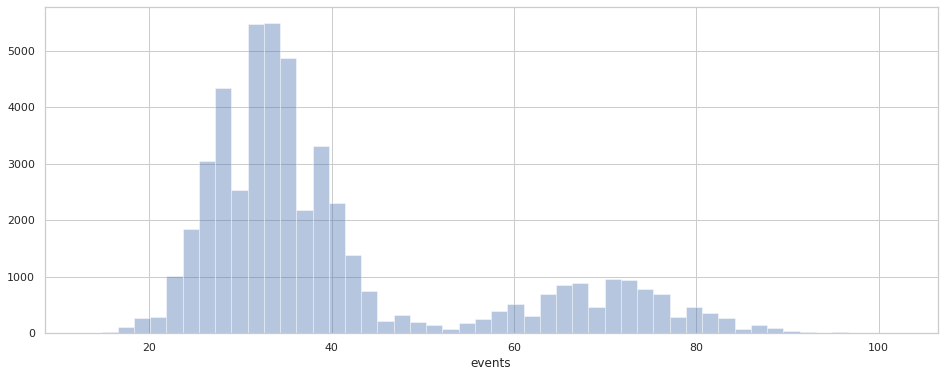

In [67]:
# график распределения тестовой группы
sns.distplot(exp2[exp2.group == 'test'].events, kde = False)

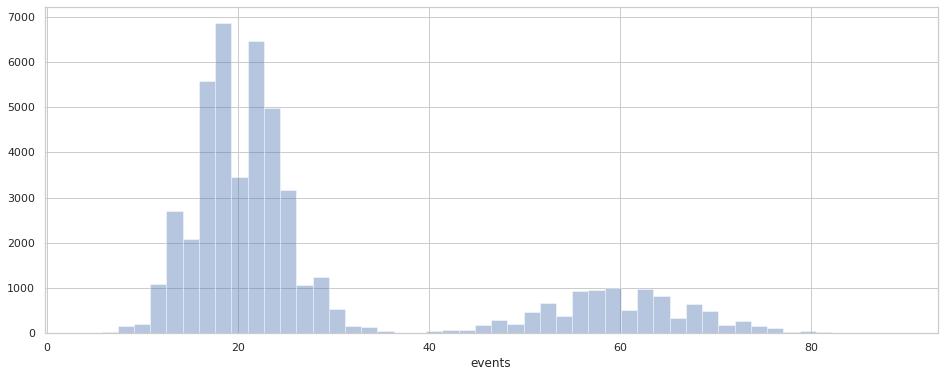

In [69]:
# график распределения контрольной группы
sns.distplot(exp2[exp2.group == 'control'].events, kde = False)

2.1. Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя

In [82]:
# разбивка по группам и сегментам
test_low = exp2.query('group == "test" and segment == "low"').events
test_high = exp2.query('group == "test" and segment == "high"').events
control_low = exp2.query('group == "control" and segment == "low"').events
control_high = exp2.query('group == "control" and segment == "high"').events
groups = [test_low,test_high, control_low, control_high]

In [107]:
# среднее, медиана и стандартное отклонение
std = []
median = []
mean = []
for group in groups:
    std.append(group.std().round(2))
    median.append(np.median(group).round(2))
    mean.append(group.mean().round(2))
    
measures = pd.DataFrame({'mean': mean,
                        'std': std,
                   'median': median},
                  index= ['test_low','test_high', 'control_low', 'control_high'])
measures
    
    

,mean,std,median
test_low,33.03,5.72,33.0
test_high,69.94,8.40,70.0
control_low,20.03,4.47,20.0
control_high,59.97,7.81,60.0


In [121]:
# воспользуемся многофакторным дисперсионным анализом для сравнения средних в группах
model = smf.ols(formula = 'events ~ segment + group + segment:group', data = exp2).fit()
aov_table = sm.stats.anova_lm(model, typ = 2)


In [124]:
print(round(aov_table, 2))

                    sum_sq       df          F  PR(>F)
segment        23624796.65      1.0  689756.38     0.0
group           3837195.41      1.0  112031.86     0.0
segment:group     36642.44      1.0    1069.82     0.0
Residual        3424955.89  99996.0        NaN     NaN


Pr(>F) < 0.05, факторы и их взаимодествие являются значимыми

In [130]:
# Проверка, между какими группами различия с помощью критерия Тъюки
exp2['combination'] = exp2.group + ' \ ' + exp2.segment
exp2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high


In [133]:
pairwise_tukeyhsd(exp2.events, groups = exp2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


Как видно, нулевая гипотеза во всех случаях отклоняется
- Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой
- Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
- Разница между control/high и test/high составила около 10


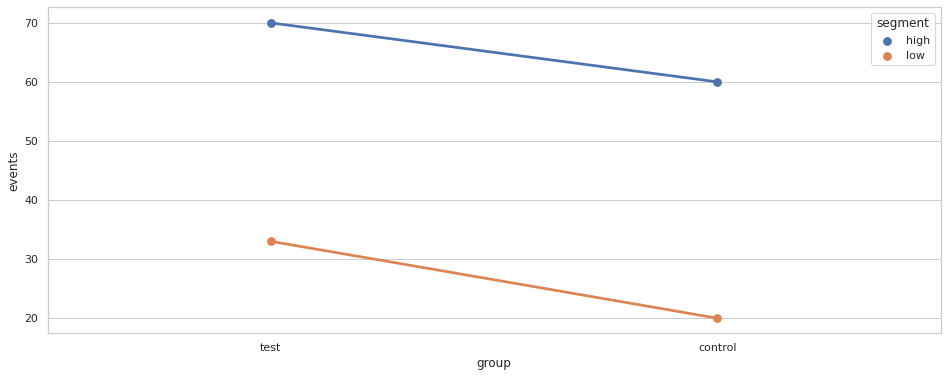

In [137]:
sns.pointplot(x = 'group', y = 'events', hue = 'segment', data = exp2, )

Итог: 
- Фактор group оказался значимым
- фактор segment – значимый
- их взаимодействие – значимо

 Судя по графику, для всех групп среднее значение events увеличилось, поэтому решение: выкатываем новую версию кнопки
